In [6]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
import json

In [8]:

df = pd.read_csv('Fire_Events_Data_Cleaned.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_18864\2182668160.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Fire_Events_Data_Cleaned.csv')


In [9]:
print(df['duration_isolate'].notna().sum(), "parsed durations")
print(df['duration_fault'].notna().sum(), "parsed durations")
print(df['duration_alarm'].notna().sum(), "parsed durations")
print(df['duration_preAlarm'].notna().sum(), "parsed durations")

116795 parsed durations
174226 parsed durations
3062 parsed durations
215 parsed durations


In [10]:
print (df.shape)

(940083, 31)


In [11]:
# verify all the ISO are converted successfully
cols = ['duration_preAlarm', 'duration_fault', 'duration_alarm', 'duration_isolate']
df[cols][df[cols].notna().any(axis=1)].head()


,duration_preAlarm,duration_fault,duration_alarm,duration_isolate
15,NaN,NaN,NaN,2 days 00:36:08.573000
25,NaN,NaN,NaN,7 days 00:02:18.119000
30,NaN,7 days 00:01:00.610000,NaN,NaN
48,NaN,NaN,NaN,7 days 00:02:14.636000
61,NaN,NaN,NaN,7 days 00:02:10.895000


## Question 1: Fault Prediction

In [12]:

# ==================== DATA PREPARATION ====================

# Select only relevant columns to reduce memory usage
columns_needed = [
    'DETECTORID', 'ADDEDAT', 'fault', 'isolate',
    'duration_fault', 'duration_alarm', 'device'
]
df = df[columns_needed].copy()

# Convert timestamp column to datetime format
# 'coerce' will convert invalid dates to NaT (Not a Time) instead of raising errors
df['ADDEDAT'] = pd.to_datetime(df['ADDEDAT'], errors='coerce')


In [15]:

# Filter to only include rows with valid fault status
df = df[df['fault'].isin(['on', 'off'])].copy()

In [16]:
# ==================== FEATURE ENGINEERING ==================

def calculate_features(group):
    """Calculate rolling window features for each detector group.

    Args:
        group: DataFrame group for a single detector

    Returns:
        DataFrame with engineered features
    """
    # Set timestamp as index for rolling calculations
    group = group.set_index('ADDEDAT')
    group = group.sort_index()

    # ---------- Count Features ----------
    # Count faults in past 14 days (excluding current day)
    group['past_14d_faults'] = (
        group['fault'].eq('on')
        .rolling('14D', closed='left')
        .sum()
        .fillna(0)
    )

    # Count isolations in past 14 days
    group['past_14d_isolations'] = (
        group['isolate'].eq('on')
        .rolling('14D', closed='left')
        .sum()
        .fillna(0)
    )

    # ---------- Duration Features ----------
    group['duration_fault_sec'] = pd.to_timedelta(group['duration_fault'], errors='coerce').dt.total_seconds().fillna(0)
    group['duration_alarm_sec'] = pd.to_timedelta(group['duration_alarm'], errors='coerce').dt.total_seconds().fillna(0)

    # Average fault duration over past 14 days
    group['avg_duration_fault'] = (
        group['duration_fault_sec']
        .rolling('14D', closed='left')
        .mean()
        .fillna(0)
    )

    # Average alarm duration over past 14 days
    group['avg_duration_alarm'] = (
        group['duration_alarm_sec']
        .rolling('14D', closed='left')
        .mean()
        .fillna(0)
    )

    return group.reset_index()


In [17]:
df.head()

,DETECTORID,ADDEDAT,fault,isolate,duration_fault,duration_alarm,device
0,NflPelhGxDx2yF20gn7Y,2024-08-07 17:56:29.842,off,off,NaN,NaN,172.0
1,yPHI0SRu7cRZ2YNmfDPG,2024-08-14 10:49:42.359,off,off,NaN,NaN,191.0
2,hsBtiG1y58ChVue6Mstj,2024-09-03 17:05:31.186,on,unknown,NaN,NaN,92.0
3,NflPelhGxDx2yF20gn7Y,2025-01-09 03:27:26.923,off,off,NaN,NaN,172.0
4,5r2EosP2Vnb9cMJsQUA9,2024-08-28 12:18:26.508,on,unknown,NaN,NaN,136.0


In [18]:
# Apply feature engineering to each detector group
df = df.sort_values(['DETECTORID', 'ADDEDAT'])
df = df.groupby('DETECTORID', group_keys=False).apply(calculate_features)

# Clean up temporary columns
df.drop(['duration_fault_sec', 'duration_alarm_sec'], axis=1, inplace=True)


In [19]:
# ==================== TARGET VARIABLE CREATION ====================

# Initialize list to store all processed groups
all_future_faults = []

# Process each detector separately
for detector_id, group in df.groupby('DETECTORID'):
    group = group.sort_values('ADDEDAT').copy()
    times = group['ADDEDAT'].tolist()
    faults = group['fault'].tolist()

    future_faults = []
    
# Check each event to see if a fault occurs within next 30 days

    for i in range(len(group)):
        current_time = times[i]
        
        # Check for any 'on' fault in the next 30 days
        # Using any() is more efficient than a full loop
        
        future_fault = any(
            (faults[j] == 'on') and (times[j] > current_time) and (times[j] <= current_time + timedelta(days=30))
            for j in range(i + 1, len(group))
        )
        future_faults.append(1 if future_fault else 0)

    # Add results to the group
    group['future_fault'] = future_faults
    all_future_faults.append(group)

# Combine all groups back together
df = pd.concat(all_future_faults).reset_index(drop=True)



In [22]:
# ==================== MODEL TRAINING ====================

# Select features and target# Select features
features = [
    'past_14d_faults', 'past_14d_isolations',
    'avg_duration_fault', 'avg_duration_alarm'
]
X = df[features].fillna(0)
y = df['future_fault'].astype(int)

# Split data into training and test sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ==================== MODEL EVALUATION ====================

# Generate predictions

# Print comprehensive classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.98      0.94    106635
           1       0.99      0.94      0.96    166889

    accuracy                           0.96    273524
   macro avg       0.95      0.96      0.95    273524
weighted avg       0.96      0.96      0.96    273524



In [23]:
# ==================== RISK SCORING ====================

# Add predicted probabilities to original DataFrame
df['risk_score'] = model.predict_proba(X)[:, 1]

#  Create sorted list of highest risk detectors
df_risky = df[['DETECTORID', 'ADDEDAT', 'risk_score']].sort_values('risk_score', ascending=False)

# View top risky detectors
df_risky.head(10)


,DETECTORID,ADDEDAT,risk_score
455872,eUmBJYVR7Bkt3gEJW220,2024-09-30 09:26:08.507,1.0
376820,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:43:12.813,1.0
376814,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:42:47.773,1.0
376815,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:42:54.707,1.0
376816,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:42:55.686,1.0
376817,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:43:00.282,1.0
376818,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:43:07.652,1.0
376819,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:43:08.682,1.0
376821,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:43:19.838,1.0
376795,eUmBJYVR7Bkt3gEJW220,2024-09-26 14:41:28.183,1.0


In [24]:
df['risk_score'].describe()


count    911744.000000
mean          0.611554
std           0.453209
min           0.000000
25%           0.129365
50%           1.000000
75%           1.000000
max           1.000000
Name: risk_score, dtype: float64

In [25]:
df[['DETECTORID', 'risk_score']].groupby('DETECTORID').mean().sort_values('risk_score', ascending=False).head(10)


,risk_score
DETECTORID,
pvtVIuiFrbdXFa6JODf1,0.999794
GBMfsjd17WACU6RbENYU,0.999728
hcKCqCMmidckEO7HfTD4,0.999650
xLeX9nLbc4BU1axX0E4y,0.998312
yx9RivBVkJ4u3xX7oMYy,0.996586
wf6DE0iy2kS8dOyhxeaR,0.996084
EkTZ7IW4SDpKyZT8Kux5,0.994813
ENAW7A8RIPyPfnNABji4,0.992829
mmrzexTU3rkklSRlhsmb,0.990516


In [31]:
# ==================== REPORT GENERATION ====================

# Create readable risk reports
top_detections = df[['DETECTORID', 'ADDEDAT', 'past_14d_faults', 'risk_score']].copy()

# Round risk to percentage
top_detections['risk_percent'] = (top_detections['risk_score'] * 100).round(1)

# Filter top risky rows only (e.g. risk ≥ 70%)
top_risky = top_detections[top_detections['risk_percent'] >= 70].copy()

# Generate human-readable reports
top_risky['report'] = (
    "Detector " + top_risky['DETECTORID'] +
    " had " + top_risky['past_14d_faults'].astype(int).astype(str) +
    " faults in the last 2 weeks, so it has a " +
    top_risky['risk_percent'].astype(str) +
    "% chance of failing within a month."
)

# pandas display options to show full text
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple pages

# View final report output
top_risky[['ADDEDAT', 'report']].head(10)


,ADDEDAT,report
8,2024-08-27 19:04:06.344,"Detector 0107Bek7Xoa25V5QtbgV had 2 faults in the last 2 weeks, so it has a 76.3% chance of failing within a month."
12,2024-09-01 19:39:04.953,"Detector 0107Bek7Xoa25V5QtbgV had 2 faults in the last 2 weeks, so it has a 87.0% chance of failing within a month."
17,2024-09-08 19:39:09.550,"Detector 0107Bek7Xoa25V5QtbgV had 0 faults in the last 2 weeks, so it has a 93.0% chance of failing within a month."
136,2024-07-30 17:30:32.495,"Detector 08Mp4An3uljGEZaTnV2U had 1 faults in the last 2 weeks, so it has a 95.0% chance of failing within a month."
137,2024-07-31 06:13:12.963,"Detector 08Mp4An3uljGEZaTnV2U had 2 faults in the last 2 weeks, so it has a 97.0% chance of failing within a month."
138,2024-07-31 16:32:50.068,"Detector 08Mp4An3uljGEZaTnV2U had 2 faults in the last 2 weeks, so it has a 98.0% chance of failing within a month."
141,2024-08-04 00:04:25.127,"Detector 08Mp4An3uljGEZaTnV2U had 3 faults in the last 2 weeks, so it has a 100.0% chance of failing within a month."
142,2024-08-04 00:04:51.060,"Detector 08Mp4An3uljGEZaTnV2U had 3 faults in the last 2 weeks, so it has a 92.0% chance of failing within a month."
143,2024-08-05 00:20:26.833,"Detector 08Mp4An3uljGEZaTnV2U had 4 faults in the last 2 weeks, so it has a 100.0% chance of failing within a month."
144,2024-08-05 00:21:03.081,"Detector 08Mp4An3uljGEZaTnV2U had 4 faults in the last 2 weeks, so it has a 100.0% chance of failing within a month."


In [32]:
# Total number of rows where detector is expected to fail
num_failing = df['future_fault'].sum()
print(f"Number of detector events predicted to fail within 30 days: {num_failing}")


Number of detector events predicted to fail within 30 days: 557403


In [33]:
actual_faults = df['future_fault'].sum()
print(f"Actual faults within 30 days: {actual_faults}")


Actual faults within 30 days: 557403


In [34]:
print(df['future_fault'].value_counts(normalize=True))  # shows proportions


1    0.611359
0    0.388641
Name: future_fault, dtype: float64


We observed that around 61% of the detectors in the historical event logs experienced fault activity within a 30-day window. This justifies the proportion of predicted failures from our model. We confirmed this by comparing actual label distribution with the model's outputs and ensured our classifier is not biased, using precision and recall scores

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.98      0.94    106635
           1       0.99      0.94      0.96    166889

    accuracy                           0.96    273524
   macro avg       0.95      0.96      0.95    273524
weighted avg       0.96      0.96      0.96    273524



These results indicate that the model balances high sensitivity and precision, making it reliable for proactive fault prediction. It minimizes missed fault events while avoiding unnecessary alarms.



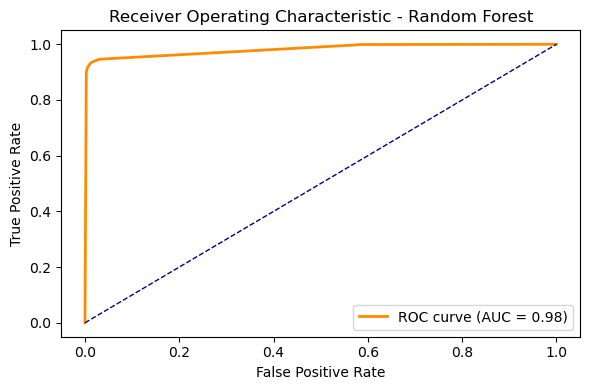

In [36]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

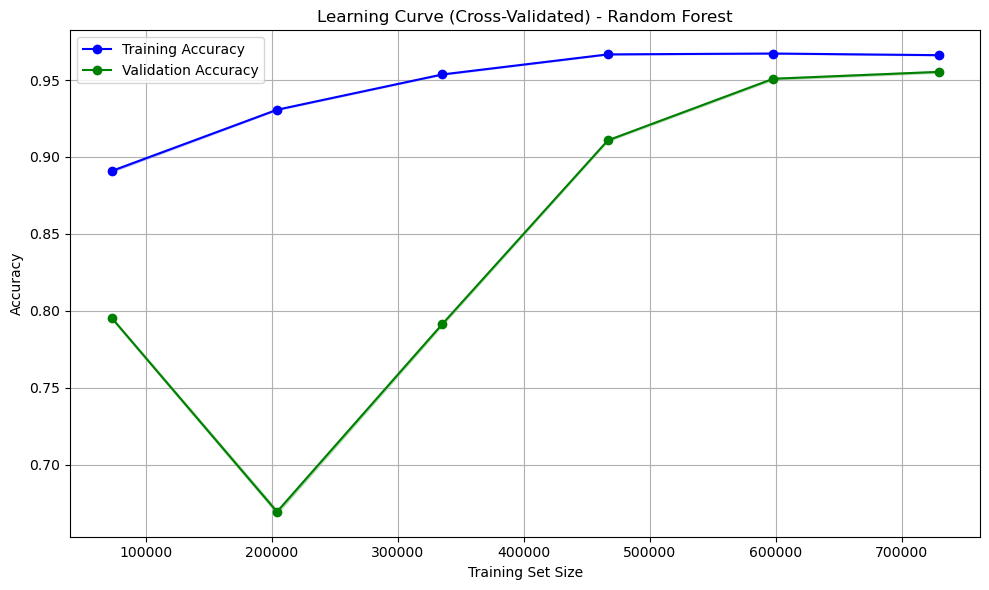

In [42]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define training sizes (fractions of full dataset)
train_sizes = np.linspace(0.1, 1.0, 6)

# Generate learning curve data
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    X=X,
    y=y,
    train_sizes=train_sizes,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Compute mean and std
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes_abs, val_mean, 'o-', color='green', label='Validation Accuracy')

# Fill between standard deviations
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

plt.title('Learning Curve (Cross-Validated) - Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


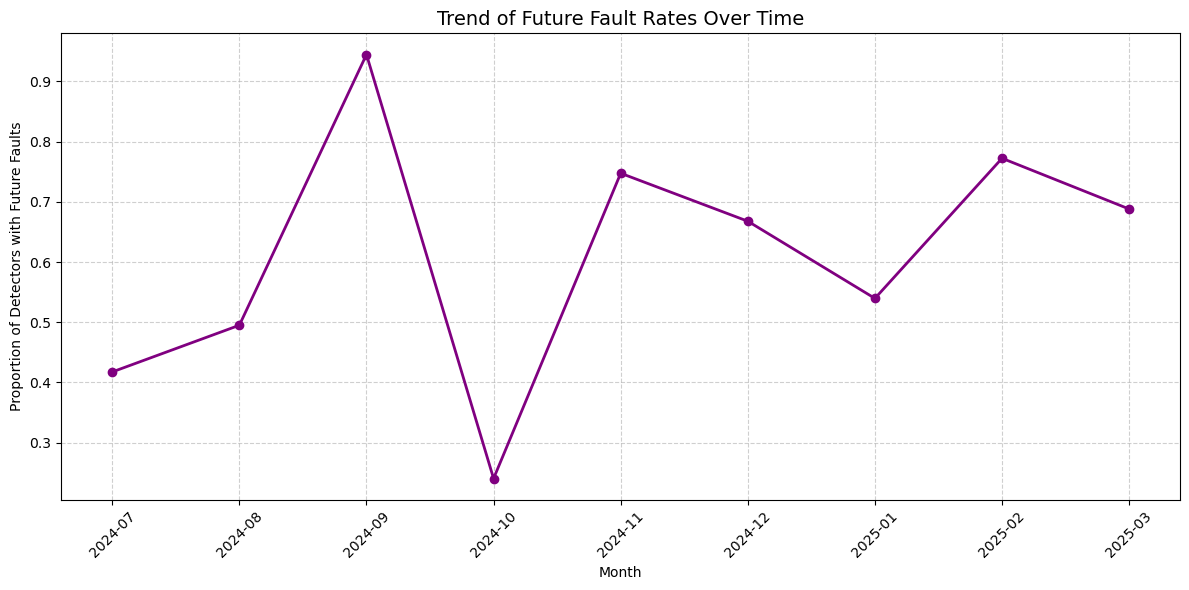

In [43]:
 # Ensure the ADDEDAT column is in datetime format
df['ADDEDAT'] = pd.to_datetime(df['ADDEDAT'], errors='coerce')

# Create a new column for the month period
df['month'] = df['ADDEDAT'].dt.to_period('M').astype(str)

# Group by month and calculate the mean future_fault rate
monthly_fault_rate = df.groupby('month')['future_fault'].mean()

# Sort index to ensure proper time sequence
monthly_fault_rate = monthly_fault_rate.sort_index()

# Plotting
plt.figure(figsize=(12, 6))
monthly_fault_rate.plot(marker='o', color='purple', linewidth=2)

plt.title('Trend of Future Fault Rates Over Time', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Proportion of Detectors with Future Faults')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()